<a href="https://colab.research.google.com/github/kishore145/AI-ML-Foundations/blob/master/Neural%20Networks/07_hyper_parameter_tuning_guidelines%20and%20code%20using%20talos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Different Hyper parameter tuning guidelines
General guidelines when manually selecting hyperparameters

> ### 1. Parameter Initialization
> 
>> 1. Biases are initialized with **zeros**  
>> 2. Weights are initialized via **glorot initializers**.  
>> 3. ReLu and tanh are used as activation function for hidden layers.  
>> 4. Sigmoid and softmax are used as activation function in o/p layers for binary and multiclass classification problems respectively.  
>> 5. Linear is used as activation function in o/p layer for regression problems.


> ### 2. Cost Function
> 
>> 1. Classification problems use **cross entropy** cost  
>> 2. Regression problem uses **quadratic/squared error** cost  


> ### 3. Getting over chance
> 
> Evaluate if the model performs better than random guessing (e.g. less than 50% accuracy in binary classification). If yes, then consider following approaches:  
> 
>> 1. Simplify the network by reducing o/p classes for testing  
>> 2. Simplify the network by reducing number of layers  
>> 3. Reduce the training data set size to iterate quicker  


> ### 4. Layers
> 
>> 1. Add or remove layers from network  
>> 2. Add or remove neurons from each layer(e.g. by power of 2  e.g. 8, 16.. )  
>> 3. Change type of layers (e.g. Convolutional, maxpooling, etc for machine vision instead of dense)

> ### 5. Prevent Overfitting
> 
>> 1. Employ **Dropouts, batch normalization, data augmentation** etc.  
>> 2. If model overfits, use weights from epoch prior to overfitting for use.  
This can be accomplished via tensorboard and saving model checkpoints  

> ### 6. Learning rate
> 
>> 1. Tune learning rate to converge to global minima quickly  
>> 2. With sophisticated optimizers like nadam, this approach is not usually required.  

> ### 7. Batch Size
> 
>> 1. Start with batch size of 32 and vary with powers of 2, but don't go beyond 128. This usually doesn't result in big changes in model performance.



# Automated Hyper Paramter Tuning

> Common libraries used are 
>> 1. Spearmint 
>> 2. Hyperopt
>> 3. Hyperas
>> 4. kopt
>> 5. talos
>
> Code examples will be added in sections below.

# Baseline CNN model for benchmarking  - fashion mnist classifier

In [0]:
!pip install git+https://github.com/autonomio/talos@1.0
# Installing talos for hyper parameter tuning

In [4]:
# Import Dependencies

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.datasets import fashion_mnist

import matplotlib.pyplot as plt
tf.version

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>

In [5]:
# Testing if GPU is allocated
# Running automated hyperparameter tuning on CPU is very slow
# Hence need to verify GPU allocation
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jun 13 15:30:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# Load dataset
(X_train, y_train), (X_valid, y_valid) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


y_train: [9 0 0 3 0 2 7 2 5 5 0 9]


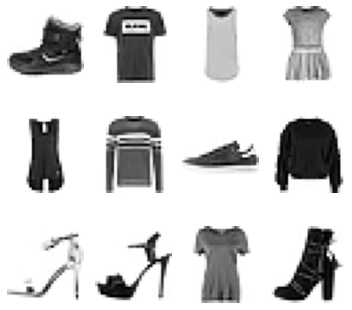

In [7]:
# Review training data
print(f'y_train: {y_train[:12]}')
plt.figure(figsize=(5,5))
for k in range(12):
    plt.subplot(3, 4, k+1)
    plt.imshow(X_train[k], cmap='Greys')
    plt.axis('off')
plt.tight_layout()
plt.show()

y_valid[0]: 9


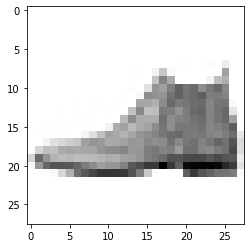

In [8]:
# review validation set
print(f'y_valid[0]: {y_valid[0]}')
plt.imshow(X_valid[0], cmap='Greys')

In [0]:
# Preprocess data
X_train = X_train.reshape(60000, 28, 28, 1).astype('float32')
X_valid = X_valid.reshape(10000, 28, 28, 1).astype('float32')

# do a min max scaling
X_train /= 255
X_valid /= 255

# One hot encode labels
n_classes = 10
y_train = to_categorical(y_train, n_classes)
y_valid = to_categorical(y_valid, n_classes)

In [0]:
# Function to create CNN model for classifying fashion mnist data
def cnn_classifier(X_train, y_train, X_valid, y_valid):
  ''' Function create, fit a CNN model on data provided and returns trained model'''

  # Define model
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))

  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(n_classes, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

  # Train model
  model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_valid, y_valid))

  # Return trained model
  return model


In [11]:
model = cnn_classifier(X_train, y_train, X_valid, y_valid)

Epoch 1/10
469/469 [==============================] - 3s 7ms/step - loss: 0.5196 - accuracy: 0.8157 - val_loss: 0.3307 - val_accuracy: 0.8836
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 0.3392 - accuracy: 0.8811 - val_loss: 0.2805 - val_accuracy: 0.8972
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 0.2907 - accuracy: 0.8965 - val_loss: 0.2743 - val_accuracy: 0.8980
Epoch 4/10
469/469 [==============================] - 3s 7ms/step - loss: 0.2591 - accuracy: 0.9068 - val_loss: 0.2477 - val_accuracy: 0.9083
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 0.2371 - accuracy: 0.9129 - val_loss: 0.2342 - val_accuracy: 0.9129
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 0.2199 - accuracy: 0.9200 - val_loss: 0.2215 - val_accuracy: 0.9198
Epoch 7/10
469/469 [==============================] - 3s 7ms/step - loss: 0.2028 - accuracy: 0.9252 - val_loss: 0.2262 - val_accuracy: 0.9178
Epoch 

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [13]:
model.evaluate(X_valid, y_valid)

313/313 [==============================] - 1s 2ms/step - loss: 0.2098 - accuracy: 0.9274


[0.2097911834716797, 0.9273999929428101]

# Hyperparameter optimization using talos

In [0]:

import talos

# Define dictionary of parameters that needs to be tuned
# Please note that the higher the number of options, the higher the time it takes to train
# Hence, removing unwanted combination options. 
p = {
    'first_conv_neurons': [64, 128],
    'first_conv_activation': ['relu'], # alternate option 'sigmoid' 
    'first_conv_kernel': [(3,3)], # (2,2)
    'second_conv_neurons': [64, 128],
    'second_conv_activation': ['relu'], # alternate option 'sigmoid'
    'second_conv_kernel': [(3,3)], # alternate option (2,2) 
    'first_max_pool_size': [(2,2)], # alternate option (3,3)
    'first_dropout': [0.25, 0.5],
    'first_dense_neurons': [128, 256],
    'second_dropout' : [0.5, 0.75],
    'optimizer': ['nadam'], # alternate option 'adam'
    'epochs' : [10], # alternate option 20
    'batch_size': [64, 128]
}



In [0]:
# Create keras model for use with talos model
# Works just like regular model creation, but replace hyperparameters with params args
def cnn_classifier_talos(X_train, y_train, X_valid, y_valid, params):
  ''' Function create, fit a CNN model on data provided and returns trained model'''

  # Define model
  model = Sequential()
  model.add(Conv2D(params['first_conv_neurons'], 
                   kernel_size=params['first_conv_kernel'],
                   activation=params['first_conv_activation'], 
                   input_shape=(28, 28, 1)))

  model.add(Conv2D(params['second_conv_neurons'], 
                   kernel_size=params['second_conv_kernel'],
                   activation=params['second_conv_activation']))
  
  model.add(MaxPooling2D(pool_size=params['first_max_pool_size']))
  model.add(Dropout(params['first_dropout']))
  
  model.add(Flatten())
  
  model.add(Dense(params['first_dense_neurons'],
                  activation='relu'))
  model.add(Dropout(params['second_dropout']))
  
  model.add(Dense(n_classes, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy', 
                optimizer=params['optimizer'], 
                metrics=['accuracy'])

  # Train model
  # make sure history object is returned by model.fit()
  history = model.fit(X_train, y_train, 
            batch_size=params['batch_size'], 
            epochs=params['epochs'], 
            verbose=1, 
            validation_data=(X_valid, y_valid))

  # Return trained model
  return history, model


In [19]:
t = talos.Scan(x=X_train, y=y_train, params=p, model=cnn_classifier_talos,
               x_val = X_valid, y_val = y_valid,
               experiment_name='fashion_mnist')


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1/10
938/938 [==============================] - 6s 6ms/step - loss: 0.4908 - accuracy: 0.8265 - val_loss: 0.3125 - val_accuracy: 0.8849
Epoch 2/10
938/938 [==============================] - 5s 6ms/step - loss: 0.3188 - accuracy: 0.8855 - val_loss: 0.2709 - val_accuracy: 0.9000
Epoch 3/10
938/938 [==============================] - 5s 6ms/step - loss: 0.2700 - accuracy: 0.9032 - val_loss: 0.2626 - val_accuracy: 0.9020
Epoch 4/10
938/938 [==============================] - 5s 6ms/step - loss: 0.2354 - accuracy: 0.9141 - val_loss: 0.2216 - val_accuracy: 0.9159
Epoch 5/10
938/938 [==============================] - 5s 6ms/step - loss: 0.2159 - accuracy: 0.9211 - val_loss: 0.2373 - val_accuracy: 0.9124
Epoch 6/10
938/938 [==============================] - 5s 6ms/step - loss: 0.1931 - accuracy: 0.9273 - val_loss: 0.2153 - val_accuracy: 0.9262
Epoch 7/10
938/938 [==============================] - 5s 6ms/step - loss: 0.1791 - accuracy: 0.9328 - val_loss: 0.2105 - val_accuracy: 0.9266
Epoch 


  2%|▏         | 1/64 [00:55<57:59, 55.23s/it]

Epoch 1/10
938/938 [==============================] - 5s 6ms/step - loss: 0.6559 - accuracy: 0.7678 - val_loss: 0.3617 - val_accuracy: 0.8719
Epoch 2/10
938/938 [==============================] - 5s 6ms/step - loss: 0.4507 - accuracy: 0.8403 - val_loss: 0.3062 - val_accuracy: 0.8893
Epoch 3/10
938/938 [==============================] - 5s 6ms/step - loss: 0.3888 - accuracy: 0.8614 - val_loss: 0.2764 - val_accuracy: 0.8975
Epoch 4/10
938/938 [==============================] - 5s 6ms/step - loss: 0.3514 - accuracy: 0.8741 - val_loss: 0.2658 - val_accuracy: 0.9040
Epoch 5/10
938/938 [==============================] - 5s 6ms/step - loss: 0.3229 - accuracy: 0.8827 - val_loss: 0.2846 - val_accuracy: 0.8951
Epoch 6/10
938/938 [==============================] - 5s 6ms/step - loss: 0.3052 - accuracy: 0.8897 - val_loss: 0.2478 - val_accuracy: 0.9102
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2897 - accuracy: 0.8948 - val_loss: 0.2380 - val_accuracy: 0.9125
Epoch 


  3%|▎         | 2/64 [01:50<57:05, 55.24s/it]

Epoch 1/10
938/938 [==============================] - 7s 7ms/step - loss: 0.4646 - accuracy: 0.8350 - val_loss: 0.2998 - val_accuracy: 0.8891
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 0.3024 - accuracy: 0.8914 - val_loss: 0.2461 - val_accuracy: 0.9100
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2566 - accuracy: 0.9063 - val_loss: 0.2358 - val_accuracy: 0.9135
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2242 - accuracy: 0.9184 - val_loss: 0.2280 - val_accuracy: 0.9163
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2023 - accuracy: 0.9248 - val_loss: 0.2222 - val_accuracy: 0.9188
Epoch 6/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1811 - accuracy: 0.9334 - val_loss: 0.2149 - val_accuracy: 0.9240
Epoch 7/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1628 - accuracy: 0.9392 - val_loss: 0.2300 - val_accuracy: 0.9216
Epoch 


  5%|▍         | 3/64 [03:00<1:00:30, 59.52s/it]

Epoch 1/10
938/938 [==============================] - 7s 7ms/step - loss: 0.6165 - accuracy: 0.7859 - val_loss: 0.3431 - val_accuracy: 0.8775
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 0.4135 - accuracy: 0.8541 - val_loss: 0.2814 - val_accuracy: 0.8958
Epoch 3/10
938/938 [==============================] - 7s 8ms/step - loss: 0.3590 - accuracy: 0.8710 - val_loss: 0.2641 - val_accuracy: 0.9055
Epoch 4/10
938/938 [==============================] - 7s 8ms/step - loss: 0.3257 - accuracy: 0.8838 - val_loss: 0.2479 - val_accuracy: 0.9078
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 0.3029 - accuracy: 0.8928 - val_loss: 0.2494 - val_accuracy: 0.9098
Epoch 6/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2818 - accuracy: 0.8989 - val_loss: 0.2346 - val_accuracy: 0.9143
Epoch 7/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2628 - accuracy: 0.9045 - val_loss: 0.2325 - val_accuracy: 0.9197
Epoch 


  6%|▋         | 4/64 [04:09<1:02:38, 62.64s/it]

Epoch 1/10
938/938 [==============================] - 5s 6ms/step - loss: 0.4873 - accuracy: 0.8258 - val_loss: 0.3580 - val_accuracy: 0.8654
Epoch 2/10
938/938 [==============================] - 5s 6ms/step - loss: 0.3322 - accuracy: 0.8815 - val_loss: 0.2751 - val_accuracy: 0.9021
Epoch 3/10
938/938 [==============================] - 5s 6ms/step - loss: 0.2895 - accuracy: 0.8947 - val_loss: 0.2476 - val_accuracy: 0.9085
Epoch 4/10
938/938 [==============================] - 5s 6ms/step - loss: 0.2649 - accuracy: 0.9029 - val_loss: 0.2366 - val_accuracy: 0.9124
Epoch 5/10
938/938 [==============================] - 5s 6ms/step - loss: 0.2422 - accuracy: 0.9110 - val_loss: 0.2259 - val_accuracy: 0.9189
Epoch 6/10
938/938 [==============================] - 5s 6ms/step - loss: 0.2260 - accuracy: 0.9174 - val_loss: 0.2200 - val_accuracy: 0.9209
Epoch 7/10
938/938 [==============================] - 5s 6ms/step - loss: 0.2141 - accuracy: 0.9204 - val_loss: 0.2214 - val_accuracy: 0.9210
Epoch 


  8%|▊         | 5/64 [05:05<59:23, 60.39s/it]  

Epoch 1/10
938/938 [==============================] - 5s 6ms/step - loss: 0.6584 - accuracy: 0.7706 - val_loss: 0.3709 - val_accuracy: 0.8662
Epoch 2/10
938/938 [==============================] - 5s 6ms/step - loss: 0.4517 - accuracy: 0.8388 - val_loss: 0.3085 - val_accuracy: 0.8867
Epoch 3/10
938/938 [==============================] - 5s 6ms/step - loss: 0.3995 - accuracy: 0.8571 - val_loss: 0.2737 - val_accuracy: 0.8990
Epoch 4/10
938/938 [==============================] - 5s 6ms/step - loss: 0.3633 - accuracy: 0.8687 - val_loss: 0.2635 - val_accuracy: 0.9046
Epoch 5/10
938/938 [==============================] - 5s 6ms/step - loss: 0.3408 - accuracy: 0.8776 - val_loss: 0.2508 - val_accuracy: 0.9080
Epoch 6/10
938/938 [==============================] - 5s 6ms/step - loss: 0.3222 - accuracy: 0.8841 - val_loss: 0.2409 - val_accuracy: 0.9130
Epoch 7/10
938/938 [==============================] - 5s 6ms/step - loss: 0.3077 - accuracy: 0.8888 - val_loss: 0.2403 - val_accuracy: 0.9139
Epoch 


  9%|▉         | 6/64 [06:00<56:48, 58.77s/it]

Epoch 1/10
938/938 [==============================] - 7s 7ms/step - loss: 0.4641 - accuracy: 0.8362 - val_loss: 0.3082 - val_accuracy: 0.8860
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 0.3123 - accuracy: 0.8866 - val_loss: 0.2680 - val_accuracy: 0.8996
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2671 - accuracy: 0.9009 - val_loss: 0.2368 - val_accuracy: 0.9134
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2414 - accuracy: 0.9120 - val_loss: 0.2251 - val_accuracy: 0.9161
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2195 - accuracy: 0.9196 - val_loss: 0.2272 - val_accuracy: 0.9160
Epoch 6/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2051 - accuracy: 0.9244 - val_loss: 0.2132 - val_accuracy: 0.9214
Epoch 7/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1911 - accuracy: 0.9296 - val_loss: 0.2047 - val_accuracy: 0.9251
Epoch 


 11%|█         | 7/64 [07:09<58:51, 61.96s/it]

Epoch 1/10
938/938 [==============================] - 7s 7ms/step - loss: 0.6180 - accuracy: 0.7829 - val_loss: 0.3477 - val_accuracy: 0.8722
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 0.4240 - accuracy: 0.8487 - val_loss: 0.2915 - val_accuracy: 0.8949
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 0.3733 - accuracy: 0.8654 - val_loss: 0.2659 - val_accuracy: 0.9027
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 0.3420 - accuracy: 0.8767 - val_loss: 0.2559 - val_accuracy: 0.9055
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 0.3196 - accuracy: 0.8844 - val_loss: 0.2363 - val_accuracy: 0.9132
Epoch 6/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2993 - accuracy: 0.8924 - val_loss: 0.2304 - val_accuracy: 0.9167
Epoch 7/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2879 - accuracy: 0.8966 - val_loss: 0.2262 - val_accuracy: 0.9179
Epoch 


 12%|█▎        | 8/64 [08:18<59:51, 64.14s/it]

Epoch 1/10
938/938 [==============================] - 6s 6ms/step - loss: 0.4344 - accuracy: 0.8455 - val_loss: 0.3086 - val_accuracy: 0.8879
Epoch 2/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2854 - accuracy: 0.8955 - val_loss: 0.2537 - val_accuracy: 0.9055
Epoch 3/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2372 - accuracy: 0.9127 - val_loss: 0.2429 - val_accuracy: 0.9101
Epoch 4/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2062 - accuracy: 0.9238 - val_loss: 0.2342 - val_accuracy: 0.9124
Epoch 5/10
938/938 [==============================] - 6s 6ms/step - loss: 0.1821 - accuracy: 0.9331 - val_loss: 0.2225 - val_accuracy: 0.9199
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 0.1591 - accuracy: 0.9403 - val_loss: 0.2082 - val_accuracy: 0.9254
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.1436 - accuracy: 0.9461 - val_loss: 0.2256 - val_accuracy: 0.9258
Epoch 


 14%|█▍        | 9/64 [09:18<57:29, 62.72s/it]

Epoch 1/10
938/938 [==============================] - 6s 6ms/step - loss: 0.5219 - accuracy: 0.8171 - val_loss: 0.3113 - val_accuracy: 0.8891
Epoch 2/10
938/938 [==============================] - 6s 6ms/step - loss: 0.3455 - accuracy: 0.8767 - val_loss: 0.2736 - val_accuracy: 0.8986
Epoch 3/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2989 - accuracy: 0.8936 - val_loss: 0.2467 - val_accuracy: 0.9114
Epoch 4/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2699 - accuracy: 0.9038 - val_loss: 0.2506 - val_accuracy: 0.9078
Epoch 5/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2485 - accuracy: 0.9111 - val_loss: 0.2287 - val_accuracy: 0.9164
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2315 - accuracy: 0.9153 - val_loss: 0.2302 - val_accuracy: 0.9179
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2178 - accuracy: 0.9215 - val_loss: 0.2187 - val_accuracy: 0.9210
Epoch 


 16%|█▌        | 10/64 [10:17<55:25, 61.58s/it]

Epoch 1/10
938/938 [==============================] - 8s 8ms/step - loss: 0.4212 - accuracy: 0.8508 - val_loss: 0.2944 - val_accuracy: 0.8934
Epoch 2/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2699 - accuracy: 0.9026 - val_loss: 0.2526 - val_accuracy: 0.9070
Epoch 3/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2222 - accuracy: 0.9177 - val_loss: 0.2225 - val_accuracy: 0.9188
Epoch 4/10
938/938 [==============================] - 8s 8ms/step - loss: 0.1899 - accuracy: 0.9295 - val_loss: 0.2234 - val_accuracy: 0.9175
Epoch 5/10
938/938 [==============================] - 8s 8ms/step - loss: 0.1638 - accuracy: 0.9393 - val_loss: 0.2287 - val_accuracy: 0.9223
Epoch 6/10
938/938 [==============================] - 8s 8ms/step - loss: 0.1446 - accuracy: 0.9452 - val_loss: 0.2106 - val_accuracy: 0.9274
Epoch 7/10
938/938 [==============================] - 8s 8ms/step - loss: 0.1249 - accuracy: 0.9521 - val_loss: 0.2301 - val_accuracy: 0.9246
Epoch 


 17%|█▋        | 11/64 [11:34<58:31, 66.26s/it]

Epoch 1/10
938/938 [==============================] - 8s 8ms/step - loss: 0.5144 - accuracy: 0.8176 - val_loss: 0.3102 - val_accuracy: 0.8886
Epoch 2/10
938/938 [==============================] - 8s 8ms/step - loss: 0.3422 - accuracy: 0.8779 - val_loss: 0.2639 - val_accuracy: 0.9002
Epoch 3/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2919 - accuracy: 0.8963 - val_loss: 0.2538 - val_accuracy: 0.9114
Epoch 4/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2608 - accuracy: 0.9068 - val_loss: 0.2303 - val_accuracy: 0.9157
Epoch 5/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2404 - accuracy: 0.9126 - val_loss: 0.2175 - val_accuracy: 0.9200
Epoch 6/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2203 - accuracy: 0.9204 - val_loss: 0.2194 - val_accuracy: 0.9223
Epoch 7/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2031 - accuracy: 0.9262 - val_loss: 0.2198 - val_accuracy: 0.9196
Epoch 


 19%|█▉        | 12/64 [12:51<1:00:15, 69.54s/it]

Epoch 1/10
938/938 [==============================] - 6s 6ms/step - loss: 0.4553 - accuracy: 0.8358 - val_loss: 0.3071 - val_accuracy: 0.8899
Epoch 2/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2999 - accuracy: 0.8905 - val_loss: 0.2678 - val_accuracy: 0.9026
Epoch 3/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2604 - accuracy: 0.9050 - val_loss: 0.2372 - val_accuracy: 0.9120
Epoch 4/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2317 - accuracy: 0.9141 - val_loss: 0.2251 - val_accuracy: 0.9168
Epoch 5/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2103 - accuracy: 0.9230 - val_loss: 0.2177 - val_accuracy: 0.9197
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 0.1944 - accuracy: 0.9281 - val_loss: 0.2202 - val_accuracy: 0.9239
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.1797 - accuracy: 0.9327 - val_loss: 0.2152 - val_accuracy: 0.9226
Epoch 


 20%|██        | 13/64 [13:50<56:27, 66.42s/it]  

Epoch 1/10
938/938 [==============================] - 6s 6ms/step - loss: 0.5551 - accuracy: 0.8039 - val_loss: 0.3367 - val_accuracy: 0.8771
Epoch 2/10
938/938 [==============================] - 6s 6ms/step - loss: 0.3782 - accuracy: 0.8657 - val_loss: 0.2889 - val_accuracy: 0.8957
Epoch 3/10
938/938 [==============================] - 6s 6ms/step - loss: 0.3272 - accuracy: 0.8833 - val_loss: 0.2644 - val_accuracy: 0.9033
Epoch 4/10
938/938 [==============================] - 6s 6ms/step - loss: 0.3016 - accuracy: 0.8898 - val_loss: 0.2541 - val_accuracy: 0.9060
Epoch 5/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2806 - accuracy: 0.8989 - val_loss: 0.2360 - val_accuracy: 0.9145
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2653 - accuracy: 0.9042 - val_loss: 0.2234 - val_accuracy: 0.9147
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2534 - accuracy: 0.9079 - val_loss: 0.2225 - val_accuracy: 0.9182
Epoch 


 22%|██▏       | 14/64 [14:49<53:25, 64.11s/it]

Epoch 1/10
938/938 [==============================] - 8s 8ms/step - loss: 0.4224 - accuracy: 0.8485 - val_loss: 0.3315 - val_accuracy: 0.8769
Epoch 2/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2793 - accuracy: 0.8979 - val_loss: 0.2446 - val_accuracy: 0.9109
Epoch 3/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2346 - accuracy: 0.9134 - val_loss: 0.2324 - val_accuracy: 0.9124
Epoch 4/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2047 - accuracy: 0.9237 - val_loss: 0.2173 - val_accuracy: 0.9196
Epoch 5/10
938/938 [==============================] - 8s 8ms/step - loss: 0.1876 - accuracy: 0.9311 - val_loss: 0.2135 - val_accuracy: 0.9261
Epoch 6/10
938/938 [==============================] - 8s 8ms/step - loss: 0.1682 - accuracy: 0.9380 - val_loss: 0.2271 - val_accuracy: 0.9224
Epoch 7/10
938/938 [==============================] - 8s 8ms/step - loss: 0.1531 - accuracy: 0.9431 - val_loss: 0.2122 - val_accuracy: 0.9289
Epoch 


 23%|██▎       | 15/64 [16:06<55:29, 67.95s/it]

Epoch 1/10
938/938 [==============================] - 8s 8ms/step - loss: 0.5306 - accuracy: 0.8151 - val_loss: 0.3555 - val_accuracy: 0.8717
Epoch 2/10
938/938 [==============================] - 8s 8ms/step - loss: 0.3528 - accuracy: 0.8741 - val_loss: 0.2687 - val_accuracy: 0.9019
Epoch 3/10
938/938 [==============================] - 8s 8ms/step - loss: 0.3081 - accuracy: 0.8901 - val_loss: 0.2570 - val_accuracy: 0.9033
Epoch 4/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2753 - accuracy: 0.8998 - val_loss: 0.2434 - val_accuracy: 0.9109
Epoch 5/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2580 - accuracy: 0.9061 - val_loss: 0.2314 - val_accuracy: 0.9164
Epoch 6/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2437 - accuracy: 0.9107 - val_loss: 0.2233 - val_accuracy: 0.9161
Epoch 7/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2257 - accuracy: 0.9183 - val_loss: 0.2171 - val_accuracy: 0.9195
Epoch 


 25%|██▌       | 16/64 [17:23<56:33, 70.70s/it]

Epoch 1/10
938/938 [==============================] - 6s 7ms/step - loss: 0.4714 - accuracy: 0.8322 - val_loss: 0.3076 - val_accuracy: 0.8874
Epoch 2/10
938/938 [==============================] - 6s 7ms/step - loss: 0.3117 - accuracy: 0.8882 - val_loss: 0.2623 - val_accuracy: 0.9041
Epoch 3/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2655 - accuracy: 0.9031 - val_loss: 0.2531 - val_accuracy: 0.9089
Epoch 4/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2388 - accuracy: 0.9127 - val_loss: 0.2237 - val_accuracy: 0.9197
Epoch 5/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2129 - accuracy: 0.9213 - val_loss: 0.2203 - val_accuracy: 0.9170
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 0.1961 - accuracy: 0.9279 - val_loss: 0.2088 - val_accuracy: 0.9259
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.1785 - accuracy: 0.9347 - val_loss: 0.2211 - val_accuracy: 0.9204
Epoch 


 27%|██▋       | 17/64 [18:25<53:24, 68.17s/it]

Epoch 1/10
938/938 [==============================] - 6s 7ms/step - loss: 0.6227 - accuracy: 0.7783 - val_loss: 0.3415 - val_accuracy: 0.8797
Epoch 2/10
938/938 [==============================] - 6s 7ms/step - loss: 0.4271 - accuracy: 0.8469 - val_loss: 0.3069 - val_accuracy: 0.8896
Epoch 3/10
938/938 [==============================] - 6s 7ms/step - loss: 0.3734 - accuracy: 0.8664 - val_loss: 0.2696 - val_accuracy: 0.9025
Epoch 4/10
938/938 [==============================] - 6s 7ms/step - loss: 0.3421 - accuracy: 0.8767 - val_loss: 0.2687 - val_accuracy: 0.9020
Epoch 5/10
938/938 [==============================] - 6s 7ms/step - loss: 0.3205 - accuracy: 0.8844 - val_loss: 0.2539 - val_accuracy: 0.9075
Epoch 6/10
938/938 [==============================] - 6s 7ms/step - loss: 0.3030 - accuracy: 0.8922 - val_loss: 0.2409 - val_accuracy: 0.9141
Epoch 7/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2843 - accuracy: 0.8956 - val_loss: 0.2435 - val_accuracy: 0.9108
Epoch 


 28%|██▊       | 18/64 [19:28<51:02, 66.57s/it]

Epoch 1/10
938/938 [==============================] - 8s 8ms/step - loss: 0.4498 - accuracy: 0.8429 - val_loss: 0.2891 - val_accuracy: 0.8965
Epoch 2/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2909 - accuracy: 0.8948 - val_loss: 0.2555 - val_accuracy: 0.9064
Epoch 3/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2451 - accuracy: 0.9103 - val_loss: 0.2401 - val_accuracy: 0.9137
Epoch 4/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2156 - accuracy: 0.9209 - val_loss: 0.2283 - val_accuracy: 0.9188
Epoch 5/10
938/938 [==============================] - 8s 8ms/step - loss: 0.1891 - accuracy: 0.9293 - val_loss: 0.2125 - val_accuracy: 0.9244
Epoch 6/10
938/938 [==============================] - 8s 8ms/step - loss: 0.1708 - accuracy: 0.9365 - val_loss: 0.2137 - val_accuracy: 0.9229
Epoch 7/10
938/938 [==============================] - 8s 8ms/step - loss: 0.1534 - accuracy: 0.9429 - val_loss: 0.2157 - val_accuracy: 0.9266
Epoch 


 30%|██▉       | 19/64 [20:46<52:36, 70.14s/it]

Epoch 1/10
938/938 [==============================] - 8s 8ms/step - loss: 0.6056 - accuracy: 0.7873 - val_loss: 0.3359 - val_accuracy: 0.8807
Epoch 2/10
938/938 [==============================] - 8s 8ms/step - loss: 0.4122 - accuracy: 0.8535 - val_loss: 0.2885 - val_accuracy: 0.8963
Epoch 3/10
938/938 [==============================] - 8s 8ms/step - loss: 0.3563 - accuracy: 0.8733 - val_loss: 0.2715 - val_accuracy: 0.8992
Epoch 4/10
938/938 [==============================] - 8s 8ms/step - loss: 0.3292 - accuracy: 0.8834 - val_loss: 0.2529 - val_accuracy: 0.9072
Epoch 5/10
938/938 [==============================] - 8s 8ms/step - loss: 0.3046 - accuracy: 0.8912 - val_loss: 0.2393 - val_accuracy: 0.9131
Epoch 6/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2836 - accuracy: 0.8978 - val_loss: 0.2331 - val_accuracy: 0.9151
Epoch 7/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2683 - accuracy: 0.9031 - val_loss: 0.2236 - val_accuracy: 0.9215
Epoch 


 31%|███▏      | 20/64 [22:05<53:19, 72.72s/it]

Epoch 1/10
938/938 [==============================] - 6s 7ms/step - loss: 0.4819 - accuracy: 0.8283 - val_loss: 0.3284 - val_accuracy: 0.8805
Epoch 2/10
938/938 [==============================] - 6s 7ms/step - loss: 0.3324 - accuracy: 0.8802 - val_loss: 0.2628 - val_accuracy: 0.9028
Epoch 3/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2857 - accuracy: 0.8960 - val_loss: 0.2472 - val_accuracy: 0.9089
Epoch 4/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2580 - accuracy: 0.9049 - val_loss: 0.2339 - val_accuracy: 0.9172
Epoch 5/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2360 - accuracy: 0.9128 - val_loss: 0.2198 - val_accuracy: 0.9193
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2231 - accuracy: 0.9181 - val_loss: 0.2085 - val_accuracy: 0.9223
Epoch 7/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2097 - accuracy: 0.9221 - val_loss: 0.2103 - val_accuracy: 0.9237
Epoch 


 33%|███▎      | 21/64 [23:07<49:52, 69.59s/it]

Epoch 1/10
938/938 [==============================] - 6s 7ms/step - loss: 0.6332 - accuracy: 0.7766 - val_loss: 0.3600 - val_accuracy: 0.8715
Epoch 2/10
938/938 [==============================] - 6s 7ms/step - loss: 0.4436 - accuracy: 0.8405 - val_loss: 0.3083 - val_accuracy: 0.8874
Epoch 3/10
938/938 [==============================] - 6s 7ms/step - loss: 0.3919 - accuracy: 0.8602 - val_loss: 0.2926 - val_accuracy: 0.8917
Epoch 4/10
938/938 [==============================] - 6s 7ms/step - loss: 0.3588 - accuracy: 0.8703 - val_loss: 0.2669 - val_accuracy: 0.9036
Epoch 5/10
938/938 [==============================] - 6s 7ms/step - loss: 0.3369 - accuracy: 0.8806 - val_loss: 0.2568 - val_accuracy: 0.9074
Epoch 6/10
938/938 [==============================] - 6s 7ms/step - loss: 0.3174 - accuracy: 0.8866 - val_loss: 0.2507 - val_accuracy: 0.9113
Epoch 7/10
938/938 [==============================] - 6s 7ms/step - loss: 0.3094 - accuracy: 0.8873 - val_loss: 0.2404 - val_accuracy: 0.9126
Epoch 


 34%|███▍      | 22/64 [24:10<47:17, 67.55s/it]

Epoch 1/10
938/938 [==============================] - 8s 8ms/step - loss: 0.4529 - accuracy: 0.8392 - val_loss: 0.2990 - val_accuracy: 0.8869
Epoch 2/10
938/938 [==============================] - 8s 8ms/step - loss: 0.3081 - accuracy: 0.8897 - val_loss: 0.2666 - val_accuracy: 0.9007
Epoch 3/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2638 - accuracy: 0.9032 - val_loss: 0.2400 - val_accuracy: 0.9112
Epoch 4/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2360 - accuracy: 0.9133 - val_loss: 0.2253 - val_accuracy: 0.9147
Epoch 5/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2169 - accuracy: 0.9201 - val_loss: 0.2205 - val_accuracy: 0.9212
Epoch 6/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2009 - accuracy: 0.9256 - val_loss: 0.2207 - val_accuracy: 0.9202
Epoch 7/10
938/938 [==============================] - 8s 8ms/step - loss: 0.1902 - accuracy: 0.9288 - val_loss: 0.2057 - val_accuracy: 0.9255
Epoch 


 36%|███▌      | 23/64 [25:29<48:23, 70.81s/it]

Epoch 1/10
938/938 [==============================] - 8s 8ms/step - loss: 0.6361 - accuracy: 0.7814 - val_loss: 0.3397 - val_accuracy: 0.8800
Epoch 2/10
938/938 [==============================] - 8s 8ms/step - loss: 0.4313 - accuracy: 0.8483 - val_loss: 0.2940 - val_accuracy: 0.8959
Epoch 3/10
938/938 [==============================] - 8s 8ms/step - loss: 0.3752 - accuracy: 0.8667 - val_loss: 0.2696 - val_accuracy: 0.9020
Epoch 4/10
938/938 [==============================] - 8s 8ms/step - loss: 0.3497 - accuracy: 0.8754 - val_loss: 0.2613 - val_accuracy: 0.9077
Epoch 5/10
938/938 [==============================] - 8s 8ms/step - loss: 0.3266 - accuracy: 0.8833 - val_loss: 0.2492 - val_accuracy: 0.9103
Epoch 6/10
938/938 [==============================] - 8s 8ms/step - loss: 0.3085 - accuracy: 0.8888 - val_loss: 0.2469 - val_accuracy: 0.9108
Epoch 7/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2943 - accuracy: 0.8941 - val_loss: 0.2356 - val_accuracy: 0.9128
Epoch 


 38%|███▊      | 24/64 [26:47<48:41, 73.04s/it]

Epoch 1/10
938/938 [==============================] - 7s 7ms/step - loss: 0.4246 - accuracy: 0.8482 - val_loss: 0.2947 - val_accuracy: 0.8953
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2762 - accuracy: 0.8996 - val_loss: 0.2561 - val_accuracy: 0.9047
Epoch 3/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2316 - accuracy: 0.9155 - val_loss: 0.2379 - val_accuracy: 0.9131
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2025 - accuracy: 0.9251 - val_loss: 0.2195 - val_accuracy: 0.9197
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1789 - accuracy: 0.9335 - val_loss: 0.2098 - val_accuracy: 0.9227
Epoch 6/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1576 - accuracy: 0.9418 - val_loss: 0.2084 - val_accuracy: 0.9273
Epoch 7/10
938/938 [==============================] - 6s 7ms/step - loss: 0.1408 - accuracy: 0.9466 - val_loss: 0.2100 - val_accuracy: 0.9270
Epoch 


 39%|███▉      | 25/64 [27:53<46:11, 71.07s/it]

Epoch 1/10
938/938 [==============================] - 7s 7ms/step - loss: 0.5237 - accuracy: 0.8158 - val_loss: 0.3227 - val_accuracy: 0.8865
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 0.3501 - accuracy: 0.8756 - val_loss: 0.2714 - val_accuracy: 0.8994
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 0.3006 - accuracy: 0.8927 - val_loss: 0.2559 - val_accuracy: 0.9040
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2729 - accuracy: 0.9020 - val_loss: 0.2374 - val_accuracy: 0.9101
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2524 - accuracy: 0.9089 - val_loss: 0.2259 - val_accuracy: 0.9169
Epoch 6/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2328 - accuracy: 0.9144 - val_loss: 0.2304 - val_accuracy: 0.9149
Epoch 7/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2197 - accuracy: 0.9185 - val_loss: 0.2209 - val_accuracy: 0.9197
Epoch 


 41%|████      | 26/64 [29:00<44:08, 69.70s/it]

Epoch 1/10
938/938 [==============================] - 9s 9ms/step - loss: 0.4187 - accuracy: 0.8493 - val_loss: 0.2928 - val_accuracy: 0.8929
Epoch 2/10
938/938 [==============================] - 9s 9ms/step - loss: 0.2681 - accuracy: 0.9021 - val_loss: 0.2424 - val_accuracy: 0.9106
Epoch 3/10
938/938 [==============================] - 9s 9ms/step - loss: 0.2220 - accuracy: 0.9184 - val_loss: 0.2245 - val_accuracy: 0.9185
Epoch 4/10
938/938 [==============================] - 9s 9ms/step - loss: 0.1911 - accuracy: 0.9290 - val_loss: 0.2058 - val_accuracy: 0.9235
Epoch 5/10
938/938 [==============================] - 9s 9ms/step - loss: 0.1658 - accuracy: 0.9386 - val_loss: 0.2065 - val_accuracy: 0.9262
Epoch 6/10
938/938 [==============================] - 9s 9ms/step - loss: 0.1425 - accuracy: 0.9467 - val_loss: 0.2093 - val_accuracy: 0.9274
Epoch 7/10
938/938 [==============================] - 9s 9ms/step - loss: 0.1265 - accuracy: 0.9530 - val_loss: 0.2169 - val_accuracy: 0.9285
Epoch 


 42%|████▏     | 27/64 [30:26<46:07, 74.80s/it]

Epoch 1/10
938/938 [==============================] - 9s 9ms/step - loss: 0.5127 - accuracy: 0.8212 - val_loss: 0.3232 - val_accuracy: 0.8802
Epoch 2/10
938/938 [==============================] - 9s 9ms/step - loss: 0.3347 - accuracy: 0.8811 - val_loss: 0.2686 - val_accuracy: 0.9006
Epoch 3/10
938/938 [==============================] - 8s 9ms/step - loss: 0.2888 - accuracy: 0.8974 - val_loss: 0.2443 - val_accuracy: 0.9072
Epoch 4/10
938/938 [==============================] - 9s 9ms/step - loss: 0.2591 - accuracy: 0.9074 - val_loss: 0.2242 - val_accuracy: 0.9153
Epoch 5/10
938/938 [==============================] - 9s 9ms/step - loss: 0.2357 - accuracy: 0.9149 - val_loss: 0.2188 - val_accuracy: 0.9170
Epoch 6/10
938/938 [==============================] - 9s 9ms/step - loss: 0.2165 - accuracy: 0.9222 - val_loss: 0.2106 - val_accuracy: 0.9269
Epoch 7/10
938/938 [==============================] - 9s 9ms/step - loss: 0.2005 - accuracy: 0.9262 - val_loss: 0.2131 - val_accuracy: 0.9235
Epoch 


 44%|████▍     | 28/64 [31:53<46:56, 78.24s/it]

Epoch 1/10
938/938 [==============================] - 7s 7ms/step - loss: 0.4439 - accuracy: 0.8393 - val_loss: 0.3041 - val_accuracy: 0.8888
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2960 - accuracy: 0.8917 - val_loss: 0.2628 - val_accuracy: 0.9029
Epoch 3/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2528 - accuracy: 0.9070 - val_loss: 0.2438 - val_accuracy: 0.9104
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2297 - accuracy: 0.9146 - val_loss: 0.2179 - val_accuracy: 0.9189
Epoch 5/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2072 - accuracy: 0.9223 - val_loss: 0.2193 - val_accuracy: 0.9217
Epoch 6/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1934 - accuracy: 0.9287 - val_loss: 0.2092 - val_accuracy: 0.9251
Epoch 7/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1777 - accuracy: 0.9343 - val_loss: 0.2140 - val_accuracy: 0.9244
Epoch 


 45%|████▌     | 29/64 [32:59<43:33, 74.67s/it]

Epoch 1/10
938/938 [==============================] - 7s 7ms/step - loss: 0.5376 - accuracy: 0.8105 - val_loss: 0.3314 - val_accuracy: 0.8786
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 0.3635 - accuracy: 0.8700 - val_loss: 0.2831 - val_accuracy: 0.8976
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 0.3194 - accuracy: 0.8849 - val_loss: 0.2577 - val_accuracy: 0.9065
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2938 - accuracy: 0.8940 - val_loss: 0.2419 - val_accuracy: 0.9090
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2757 - accuracy: 0.9014 - val_loss: 0.2292 - val_accuracy: 0.9160
Epoch 6/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2624 - accuracy: 0.9048 - val_loss: 0.2223 - val_accuracy: 0.9203
Epoch 7/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2468 - accuracy: 0.9099 - val_loss: 0.2252 - val_accuracy: 0.9165
Epoch 


 47%|████▋     | 30/64 [34:05<40:52, 72.14s/it]

Epoch 1/10
938/938 [==============================] - 9s 9ms/step - loss: 0.4221 - accuracy: 0.8493 - val_loss: 0.2844 - val_accuracy: 0.8964
Epoch 2/10
938/938 [==============================] - 9s 9ms/step - loss: 0.2771 - accuracy: 0.8981 - val_loss: 0.2490 - val_accuracy: 0.9072
Epoch 3/10
938/938 [==============================] - 9s 9ms/step - loss: 0.2375 - accuracy: 0.9127 - val_loss: 0.2284 - val_accuracy: 0.9137
Epoch 4/10
938/938 [==============================] - 8s 9ms/step - loss: 0.2106 - accuracy: 0.9221 - val_loss: 0.2188 - val_accuracy: 0.9180
Epoch 5/10
938/938 [==============================] - 9s 9ms/step - loss: 0.1914 - accuracy: 0.9287 - val_loss: 0.2092 - val_accuracy: 0.9248
Epoch 6/10
938/938 [==============================] - 8s 9ms/step - loss: 0.1730 - accuracy: 0.9359 - val_loss: 0.2137 - val_accuracy: 0.9250
Epoch 7/10
938/938 [==============================] - 9s 9ms/step - loss: 0.1583 - accuracy: 0.9416 - val_loss: 0.2120 - val_accuracy: 0.9276
Epoch 


 48%|████▊     | 31/64 [35:32<42:04, 76.51s/it]

Epoch 1/10
938/938 [==============================] - 9s 9ms/step - loss: 0.5219 - accuracy: 0.8159 - val_loss: 0.3194 - val_accuracy: 0.8867
Epoch 2/10
938/938 [==============================] - 9s 9ms/step - loss: 0.3540 - accuracy: 0.8732 - val_loss: 0.2712 - val_accuracy: 0.9008
Epoch 3/10
938/938 [==============================] - 9s 9ms/step - loss: 0.3105 - accuracy: 0.8886 - val_loss: 0.2468 - val_accuracy: 0.9079
Epoch 4/10
938/938 [==============================] - 8s 9ms/step - loss: 0.2809 - accuracy: 0.8984 - val_loss: 0.2389 - val_accuracy: 0.9094
Epoch 5/10
938/938 [==============================] - 9s 9ms/step - loss: 0.2601 - accuracy: 0.9061 - val_loss: 0.2356 - val_accuracy: 0.9124
Epoch 6/10
938/938 [==============================] - 8s 9ms/step - loss: 0.2423 - accuracy: 0.9110 - val_loss: 0.2216 - val_accuracy: 0.9192
Epoch 7/10
938/938 [==============================] - 8s 9ms/step - loss: 0.2319 - accuracy: 0.9149 - val_loss: 0.2203 - val_accuracy: 0.9197
Epoch 


 50%|█████     | 32/64 [36:58<42:21, 79.42s/it]

Epoch 1/10
469/469 [==============================] - 4s 8ms/step - loss: 0.5034 - accuracy: 0.8242 - val_loss: 0.3235 - val_accuracy: 0.8862
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3267 - accuracy: 0.8828 - val_loss: 0.2786 - val_accuracy: 0.9010
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2799 - accuracy: 0.8979 - val_loss: 0.2526 - val_accuracy: 0.9083
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2487 - accuracy: 0.9100 - val_loss: 0.2344 - val_accuracy: 0.9149
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2246 - accuracy: 0.9184 - val_loss: 0.2236 - val_accuracy: 0.9174
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2059 - accuracy: 0.9228 - val_loss: 0.2259 - val_accuracy: 0.9184
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1880 - accuracy: 0.9305 - val_loss: 0.2111 - val_accuracy: 0.9232
Epoch 


 52%|█████▏    | 33/64 [37:36<34:32, 66.87s/it]

Epoch 1/10
469/469 [==============================] - 4s 8ms/step - loss: 0.6740 - accuracy: 0.7634 - val_loss: 0.3706 - val_accuracy: 0.8702
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.4532 - accuracy: 0.8396 - val_loss: 0.3087 - val_accuracy: 0.8908
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3949 - accuracy: 0.8596 - val_loss: 0.3013 - val_accuracy: 0.8915
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3546 - accuracy: 0.8741 - val_loss: 0.2683 - val_accuracy: 0.9034
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3273 - accuracy: 0.8823 - val_loss: 0.2544 - val_accuracy: 0.9118
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3123 - accuracy: 0.8889 - val_loss: 0.2444 - val_accuracy: 0.9134
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2896 - accuracy: 0.8958 - val_loss: 0.2377 - val_accuracy: 0.9177
Epoch 


 53%|█████▎    | 34/64 [38:13<29:00, 58.03s/it]

Epoch 1/10
469/469 [==============================] - 5s 11ms/step - loss: 0.4874 - accuracy: 0.8280 - val_loss: 0.3010 - val_accuracy: 0.8923
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 0.3088 - accuracy: 0.8903 - val_loss: 0.2768 - val_accuracy: 0.8965
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2605 - accuracy: 0.9063 - val_loss: 0.2527 - val_accuracy: 0.9073
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2259 - accuracy: 0.9175 - val_loss: 0.2325 - val_accuracy: 0.9170
Epoch 5/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2014 - accuracy: 0.9256 - val_loss: 0.2198 - val_accuracy: 0.9214
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1809 - accuracy: 0.9330 - val_loss: 0.2134 - val_accuracy: 0.9250
Epoch 7/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1648 - accuracy: 0.9390 - val_loss: 0.2153 - val_accuracy: 0.9236


 55%|█████▍    | 35/64 [39:03<26:47, 55.43s/it]

Epoch 1/10
469/469 [==============================] - 5s 10ms/step - loss: 0.6206 - accuracy: 0.7836 - val_loss: 0.3398 - val_accuracy: 0.8785
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 0.4116 - accuracy: 0.8544 - val_loss: 0.2954 - val_accuracy: 0.8939
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 0.3528 - accuracy: 0.8749 - val_loss: 0.2743 - val_accuracy: 0.9007
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - loss: 0.3198 - accuracy: 0.8846 - val_loss: 0.2518 - val_accuracy: 0.9080
Epoch 5/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2938 - accuracy: 0.8939 - val_loss: 0.2415 - val_accuracy: 0.9122
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2742 - accuracy: 0.9016 - val_loss: 0.2356 - val_accuracy: 0.9137
Epoch 7/10
469/469 [==============================] - 5s 11ms/step - loss: 0.2569 - accuracy: 0.9071 - val_loss: 0.2232 - val_accuracy: 0.9194


 56%|█████▋    | 36/64 [39:52<25:04, 53.72s/it]

Epoch 1/10
469/469 [==============================] - 4s 8ms/step - loss: 0.5206 - accuracy: 0.8173 - val_loss: 0.3379 - val_accuracy: 0.8793
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3447 - accuracy: 0.8762 - val_loss: 0.2926 - val_accuracy: 0.8901
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2994 - accuracy: 0.8920 - val_loss: 0.2645 - val_accuracy: 0.9003
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2715 - accuracy: 0.9010 - val_loss: 0.2612 - val_accuracy: 0.9022
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2476 - accuracy: 0.9085 - val_loss: 0.2346 - val_accuracy: 0.9182
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2336 - accuracy: 0.9141 - val_loss: 0.2354 - val_accuracy: 0.9120
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2189 - accuracy: 0.9196 - val_loss: 0.2230 - val_accuracy: 0.9168
Epoch 


 58%|█████▊    | 37/64 [40:30<21:58, 48.82s/it]

Epoch 1/10
469/469 [==============================] - 4s 8ms/step - loss: 0.6907 - accuracy: 0.7556 - val_loss: 0.3940 - val_accuracy: 0.8562
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.4777 - accuracy: 0.8301 - val_loss: 0.3329 - val_accuracy: 0.8807
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.4207 - accuracy: 0.8500 - val_loss: 0.3208 - val_accuracy: 0.8819
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3819 - accuracy: 0.8622 - val_loss: 0.2727 - val_accuracy: 0.9025
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3570 - accuracy: 0.8726 - val_loss: 0.2784 - val_accuracy: 0.9016
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3347 - accuracy: 0.8787 - val_loss: 0.2512 - val_accuracy: 0.9085
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3230 - accuracy: 0.8835 - val_loss: 0.2423 - val_accuracy: 0.9108
Epoch 


 59%|█████▉    | 38/64 [41:07<19:40, 45.41s/it]

Epoch 1/10
469/469 [==============================] - 5s 10ms/step - loss: 0.5031 - accuracy: 0.8257 - val_loss: 0.3509 - val_accuracy: 0.8705
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 0.3291 - accuracy: 0.8824 - val_loss: 0.2692 - val_accuracy: 0.9023
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2830 - accuracy: 0.8988 - val_loss: 0.2549 - val_accuracy: 0.9047
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2534 - accuracy: 0.9080 - val_loss: 0.2367 - val_accuracy: 0.9139
Epoch 5/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2273 - accuracy: 0.9168 - val_loss: 0.2267 - val_accuracy: 0.9179
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2091 - accuracy: 0.9222 - val_loss: 0.2213 - val_accuracy: 0.9219
Epoch 7/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1934 - accuracy: 0.9284 - val_loss: 0.2233 - val_accuracy: 0.9184


 61%|██████    | 39/64 [41:57<19:24, 46.60s/it]

Epoch 1/10
469/469 [==============================] - 5s 11ms/step - loss: 0.6731 - accuracy: 0.7659 - val_loss: 0.3619 - val_accuracy: 0.8692
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 0.4522 - accuracy: 0.8405 - val_loss: 0.3042 - val_accuracy: 0.8902
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 0.3900 - accuracy: 0.8636 - val_loss: 0.2753 - val_accuracy: 0.9020
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - loss: 0.3556 - accuracy: 0.8731 - val_loss: 0.2696 - val_accuracy: 0.9022
Epoch 5/10
469/469 [==============================] - 5s 10ms/step - loss: 0.3302 - accuracy: 0.8826 - val_loss: 0.2563 - val_accuracy: 0.9082
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 0.3092 - accuracy: 0.8892 - val_loss: 0.2427 - val_accuracy: 0.9116
Epoch 7/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2931 - accuracy: 0.8943 - val_loss: 0.2341 - val_accuracy: 0.9171


 62%|██████▎   | 40/64 [42:46<18:59, 47.47s/it]

Epoch 1/10
469/469 [==============================] - 4s 9ms/step - loss: 0.4606 - accuracy: 0.8382 - val_loss: 0.3162 - val_accuracy: 0.8839
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2910 - accuracy: 0.8945 - val_loss: 0.2586 - val_accuracy: 0.9041
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2421 - accuracy: 0.9113 - val_loss: 0.2383 - val_accuracy: 0.9103
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2102 - accuracy: 0.9232 - val_loss: 0.2414 - val_accuracy: 0.9114
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1852 - accuracy: 0.9315 - val_loss: 0.2186 - val_accuracy: 0.9212
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1639 - accuracy: 0.9403 - val_loss: 0.2104 - val_accuracy: 0.9233
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1465 - accuracy: 0.9445 - val_loss: 0.2126 - val_accuracy: 0.9245
Epoch 


 64%|██████▍   | 41/64 [43:27<17:23, 45.37s/it]

Epoch 1/10
469/469 [==============================] - 4s 9ms/step - loss: 0.5485 - accuracy: 0.8065 - val_loss: 0.3267 - val_accuracy: 0.8810
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3619 - accuracy: 0.8723 - val_loss: 0.2767 - val_accuracy: 0.9008
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3112 - accuracy: 0.8889 - val_loss: 0.2546 - val_accuracy: 0.9062
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2826 - accuracy: 0.8994 - val_loss: 0.2370 - val_accuracy: 0.9118
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2550 - accuracy: 0.9074 - val_loss: 0.2292 - val_accuracy: 0.9182
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2384 - accuracy: 0.9137 - val_loss: 0.2168 - val_accuracy: 0.9213
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2202 - accuracy: 0.9194 - val_loss: 0.2189 - val_accuracy: 0.9204
Epoch 


 66%|██████▌   | 42/64 [44:07<16:05, 43.89s/it]

Epoch 1/10
469/469 [==============================] - 5s 12ms/step - loss: 0.4534 - accuracy: 0.8384 - val_loss: 0.3061 - val_accuracy: 0.8876
Epoch 2/10
469/469 [==============================] - 5s 12ms/step - loss: 0.2779 - accuracy: 0.9000 - val_loss: 0.2706 - val_accuracy: 0.8977
Epoch 3/10
469/469 [==============================] - 5s 12ms/step - loss: 0.2303 - accuracy: 0.9153 - val_loss: 0.2232 - val_accuracy: 0.9168
Epoch 4/10
469/469 [==============================] - 5s 12ms/step - loss: 0.1973 - accuracy: 0.9265 - val_loss: 0.2185 - val_accuracy: 0.9213
Epoch 5/10
469/469 [==============================] - 5s 12ms/step - loss: 0.1717 - accuracy: 0.9360 - val_loss: 0.2193 - val_accuracy: 0.9237
Epoch 6/10
469/469 [==============================] - 5s 12ms/step - loss: 0.1490 - accuracy: 0.9444 - val_loss: 0.2008 - val_accuracy: 0.9275
Epoch 7/10
469/469 [==============================] - 6s 12ms/step - loss: 0.1305 - accuracy: 0.9517 - val_loss: 0.2100 - val_accuracy: 0.9311


 67%|██████▋   | 43/64 [45:03<16:35, 47.39s/it]

Epoch 1/10
469/469 [==============================] - 5s 12ms/step - loss: 0.5605 - accuracy: 0.8060 - val_loss: 0.3356 - val_accuracy: 0.8801
Epoch 2/10
469/469 [==============================] - 5s 12ms/step - loss: 0.3566 - accuracy: 0.8743 - val_loss: 0.2737 - val_accuracy: 0.8997
Epoch 3/10
469/469 [==============================] - 5s 12ms/step - loss: 0.3059 - accuracy: 0.8916 - val_loss: 0.2484 - val_accuracy: 0.9087
Epoch 4/10
469/469 [==============================] - 5s 12ms/step - loss: 0.2661 - accuracy: 0.9049 - val_loss: 0.2330 - val_accuracy: 0.9157
Epoch 5/10
469/469 [==============================] - 5s 12ms/step - loss: 0.2469 - accuracy: 0.9118 - val_loss: 0.2226 - val_accuracy: 0.9174
Epoch 6/10
469/469 [==============================] - 5s 12ms/step - loss: 0.2226 - accuracy: 0.9197 - val_loss: 0.2207 - val_accuracy: 0.9215
Epoch 7/10
469/469 [==============================] - 5s 12ms/step - loss: 0.2092 - accuracy: 0.9235 - val_loss: 0.2135 - val_accuracy: 0.9226


 69%|██████▉   | 44/64 [45:58<16:35, 49.79s/it]

Epoch 1/10
469/469 [==============================] - 4s 9ms/step - loss: 0.4820 - accuracy: 0.8278 - val_loss: 0.3089 - val_accuracy: 0.8890
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3126 - accuracy: 0.8859 - val_loss: 0.2662 - val_accuracy: 0.9023
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2686 - accuracy: 0.9021 - val_loss: 0.2469 - val_accuracy: 0.9112
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2382 - accuracy: 0.9126 - val_loss: 0.2264 - val_accuracy: 0.9182
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2141 - accuracy: 0.9203 - val_loss: 0.2170 - val_accuracy: 0.9223
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1980 - accuracy: 0.9277 - val_loss: 0.2102 - val_accuracy: 0.9220
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1828 - accuracy: 0.9315 - val_loss: 0.2019 - val_accuracy: 0.9266
Epoch 


 70%|███████   | 45/64 [46:38<14:52, 46.96s/it]

Epoch 1/10
469/469 [==============================] - 4s 9ms/step - loss: 0.5750 - accuracy: 0.7962 - val_loss: 0.3432 - val_accuracy: 0.8771
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3860 - accuracy: 0.8640 - val_loss: 0.3008 - val_accuracy: 0.8910
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3335 - accuracy: 0.8812 - val_loss: 0.2608 - val_accuracy: 0.9060
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3065 - accuracy: 0.8907 - val_loss: 0.2512 - val_accuracy: 0.9089
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2842 - accuracy: 0.8979 - val_loss: 0.2474 - val_accuracy: 0.9062
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2688 - accuracy: 0.9032 - val_loss: 0.2320 - val_accuracy: 0.9131
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2525 - accuracy: 0.9070 - val_loss: 0.2341 - val_accuracy: 0.9143
Epoch 


 72%|███████▏  | 46/64 [47:19<13:29, 45.00s/it]

Epoch 1/10
469/469 [==============================] - 6s 12ms/step - loss: 0.4602 - accuracy: 0.8358 - val_loss: 0.3071 - val_accuracy: 0.8871
Epoch 2/10
469/469 [==============================] - 5s 12ms/step - loss: 0.2902 - accuracy: 0.8938 - val_loss: 0.2584 - val_accuracy: 0.9048
Epoch 3/10
469/469 [==============================] - 5s 12ms/step - loss: 0.2460 - accuracy: 0.9090 - val_loss: 0.2422 - val_accuracy: 0.9096
Epoch 4/10
469/469 [==============================] - 5s 12ms/step - loss: 0.2157 - accuracy: 0.9200 - val_loss: 0.2208 - val_accuracy: 0.9185
Epoch 5/10
469/469 [==============================] - 5s 12ms/step - loss: 0.1906 - accuracy: 0.9292 - val_loss: 0.2188 - val_accuracy: 0.9213
Epoch 6/10
469/469 [==============================] - 5s 12ms/step - loss: 0.1714 - accuracy: 0.9364 - val_loss: 0.2160 - val_accuracy: 0.9239
Epoch 7/10
469/469 [==============================] - 5s 12ms/step - loss: 0.1574 - accuracy: 0.9426 - val_loss: 0.2023 - val_accuracy: 0.9269


 73%|███████▎  | 47/64 [48:14<13:38, 48.12s/it]

Epoch 1/10
469/469 [==============================] - 6s 12ms/step - loss: 0.5555 - accuracy: 0.8034 - val_loss: 0.3405 - val_accuracy: 0.8761
Epoch 2/10
469/469 [==============================] - 5s 12ms/step - loss: 0.3714 - accuracy: 0.8672 - val_loss: 0.2840 - val_accuracy: 0.8967
Epoch 3/10
469/469 [==============================] - 5s 12ms/step - loss: 0.3205 - accuracy: 0.8850 - val_loss: 0.2607 - val_accuracy: 0.9025
Epoch 4/10
469/469 [==============================] - 5s 12ms/step - loss: 0.2893 - accuracy: 0.8953 - val_loss: 0.2436 - val_accuracy: 0.9090
Epoch 5/10
469/469 [==============================] - 5s 12ms/step - loss: 0.2689 - accuracy: 0.9039 - val_loss: 0.2390 - val_accuracy: 0.9125
Epoch 6/10
469/469 [==============================] - 5s 12ms/step - loss: 0.2544 - accuracy: 0.9084 - val_loss: 0.2238 - val_accuracy: 0.9179
Epoch 7/10
469/469 [==============================] - 5s 12ms/step - loss: 0.2347 - accuracy: 0.9149 - val_loss: 0.2207 - val_accuracy: 0.9198


 75%|███████▌  | 48/64 [49:09<13:24, 50.29s/it]

Epoch 1/10
469/469 [==============================] - 4s 10ms/step - loss: 0.5045 - accuracy: 0.8237 - val_loss: 0.3106 - val_accuracy: 0.8885
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 0.3215 - accuracy: 0.8849 - val_loss: 0.2631 - val_accuracy: 0.9043
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2768 - accuracy: 0.8996 - val_loss: 0.2530 - val_accuracy: 0.9078
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2446 - accuracy: 0.9117 - val_loss: 0.2528 - val_accuracy: 0.9075
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2223 - accuracy: 0.9192 - val_loss: 0.2217 - val_accuracy: 0.9174
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2070 - accuracy: 0.9237 - val_loss: 0.2200 - val_accuracy: 0.9209
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1900 - accuracy: 0.9299 - val_loss: 0.2175 - val_accuracy: 0.9232
Epoch


 77%|███████▋  | 49/64 [49:54<12:08, 48.60s/it]

Epoch 1/10
469/469 [==============================] - 5s 10ms/step - loss: 0.6632 - accuracy: 0.7691 - val_loss: 0.3606 - val_accuracy: 0.8703
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 0.4404 - accuracy: 0.8452 - val_loss: 0.3017 - val_accuracy: 0.8951
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 0.3832 - accuracy: 0.8654 - val_loss: 0.2915 - val_accuracy: 0.8950
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 0.3524 - accuracy: 0.8745 - val_loss: 0.2654 - val_accuracy: 0.9037
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 0.3242 - accuracy: 0.8850 - val_loss: 0.2500 - val_accuracy: 0.9081
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 0.3043 - accuracy: 0.8900 - val_loss: 0.2357 - val_accuracy: 0.9147
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2875 - accuracy: 0.8968 - val_loss: 0.2360 - val_accuracy: 0.9161
Epoch


 78%|███████▊  | 50/64 [50:39<11:04, 47.44s/it]

Epoch 1/10
469/469 [==============================] - 6s 12ms/step - loss: 0.4822 - accuracy: 0.8293 - val_loss: 0.3126 - val_accuracy: 0.8897
Epoch 2/10
469/469 [==============================] - 6s 12ms/step - loss: 0.3071 - accuracy: 0.8893 - val_loss: 0.2558 - val_accuracy: 0.9058
Epoch 3/10
469/469 [==============================] - 6s 12ms/step - loss: 0.2593 - accuracy: 0.9064 - val_loss: 0.2376 - val_accuracy: 0.9100
Epoch 4/10
469/469 [==============================] - 6s 12ms/step - loss: 0.2278 - accuracy: 0.9167 - val_loss: 0.2334 - val_accuracy: 0.9164
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 0.2038 - accuracy: 0.9244 - val_loss: 0.2183 - val_accuracy: 0.9216
Epoch 6/10
469/469 [==============================] - 6s 12ms/step - loss: 0.1838 - accuracy: 0.9317 - val_loss: 0.2135 - val_accuracy: 0.9249
Epoch 7/10
469/469 [==============================] - 6s 12ms/step - loss: 0.1686 - accuracy: 0.9372 - val_loss: 0.2156 - val_accuracy: 0.9220


 80%|███████▉  | 51/64 [51:37<10:59, 50.72s/it]

Epoch 1/10
469/469 [==============================] - 6s 12ms/step - loss: 0.6403 - accuracy: 0.7778 - val_loss: 0.3501 - val_accuracy: 0.8710
Epoch 2/10
469/469 [==============================] - 6s 12ms/step - loss: 0.4261 - accuracy: 0.8485 - val_loss: 0.3105 - val_accuracy: 0.8866
Epoch 3/10
469/469 [==============================] - 6s 12ms/step - loss: 0.3649 - accuracy: 0.8697 - val_loss: 0.2796 - val_accuracy: 0.8996
Epoch 4/10
469/469 [==============================] - 6s 12ms/step - loss: 0.3311 - accuracy: 0.8821 - val_loss: 0.2585 - val_accuracy: 0.9056
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 0.3048 - accuracy: 0.8909 - val_loss: 0.2378 - val_accuracy: 0.9160
Epoch 6/10
469/469 [==============================] - 6s 12ms/step - loss: 0.2837 - accuracy: 0.8964 - val_loss: 0.2303 - val_accuracy: 0.9168
Epoch 7/10
469/469 [==============================] - 6s 12ms/step - loss: 0.2666 - accuracy: 0.9032 - val_loss: 0.2326 - val_accuracy: 0.9208


 81%|████████▏ | 52/64 [52:35<10:35, 52.95s/it]

Epoch 1/10
469/469 [==============================] - 4s 9ms/step - loss: 0.5075 - accuracy: 0.8213 - val_loss: 0.3338 - val_accuracy: 0.8786
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 0.3400 - accuracy: 0.8787 - val_loss: 0.2762 - val_accuracy: 0.8957
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2933 - accuracy: 0.8940 - val_loss: 0.2561 - val_accuracy: 0.9048
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2646 - accuracy: 0.9034 - val_loss: 0.2463 - val_accuracy: 0.9098
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2419 - accuracy: 0.9103 - val_loss: 0.2258 - val_accuracy: 0.9165
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2262 - accuracy: 0.9174 - val_loss: 0.2226 - val_accuracy: 0.9191
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2118 - accuracy: 0.9219 - val_loss: 0.2181 - val_accuracy: 0.9201
Epoch 


 83%|████████▎ | 53/64 [53:20<09:14, 50.42s/it]

Epoch 1/10
469/469 [==============================] - 4s 10ms/step - loss: 0.6667 - accuracy: 0.7648 - val_loss: 0.3712 - val_accuracy: 0.8613
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 0.4535 - accuracy: 0.8394 - val_loss: 0.3165 - val_accuracy: 0.8897
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 0.3952 - accuracy: 0.8583 - val_loss: 0.2928 - val_accuracy: 0.8925
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 0.3630 - accuracy: 0.8684 - val_loss: 0.2743 - val_accuracy: 0.9018
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 0.3390 - accuracy: 0.8785 - val_loss: 0.2503 - val_accuracy: 0.9097
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 0.3239 - accuracy: 0.8836 - val_loss: 0.2489 - val_accuracy: 0.9085
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 0.3093 - accuracy: 0.8897 - val_loss: 0.2395 - val_accuracy: 0.9122
Epoch


 84%|████████▍ | 54/64 [54:04<08:06, 48.67s/it]

Epoch 1/10
469/469 [==============================] - 6s 12ms/step - loss: 0.4891 - accuracy: 0.8284 - val_loss: 0.3233 - val_accuracy: 0.8840
Epoch 2/10
469/469 [==============================] - 6s 12ms/step - loss: 0.3232 - accuracy: 0.8846 - val_loss: 0.2759 - val_accuracy: 0.9023
Epoch 3/10
469/469 [==============================] - 6s 12ms/step - loss: 0.2774 - accuracy: 0.8986 - val_loss: 0.2452 - val_accuracy: 0.9100
Epoch 4/10
469/469 [==============================] - 6s 12ms/step - loss: 0.2460 - accuracy: 0.9104 - val_loss: 0.2404 - val_accuracy: 0.9105
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 0.2246 - accuracy: 0.9167 - val_loss: 0.2174 - val_accuracy: 0.9192
Epoch 6/10
469/469 [==============================] - 6s 12ms/step - loss: 0.2094 - accuracy: 0.9220 - val_loss: 0.2218 - val_accuracy: 0.9221
Epoch 7/10
469/469 [==============================] - 6s 12ms/step - loss: 0.1948 - accuracy: 0.9282 - val_loss: 0.2151 - val_accuracy: 0.9247


 86%|████████▌ | 55/64 [55:03<07:43, 51.51s/it]

Epoch 1/10
469/469 [==============================] - 6s 13ms/step - loss: 0.6280 - accuracy: 0.7798 - val_loss: 0.3517 - val_accuracy: 0.8709
Epoch 2/10
469/469 [==============================] - 6s 12ms/step - loss: 0.4221 - accuracy: 0.8507 - val_loss: 0.3002 - val_accuracy: 0.8942
Epoch 3/10
469/469 [==============================] - 6s 12ms/step - loss: 0.3746 - accuracy: 0.8671 - val_loss: 0.2748 - val_accuracy: 0.9000
Epoch 4/10
469/469 [==============================] - 6s 12ms/step - loss: 0.3409 - accuracy: 0.8770 - val_loss: 0.2565 - val_accuracy: 0.9082
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 0.3127 - accuracy: 0.8881 - val_loss: 0.2527 - val_accuracy: 0.9062
Epoch 6/10
469/469 [==============================] - 6s 12ms/step - loss: 0.2943 - accuracy: 0.8942 - val_loss: 0.2354 - val_accuracy: 0.9129
Epoch 7/10
469/469 [==============================] - 6s 12ms/step - loss: 0.2815 - accuracy: 0.8996 - val_loss: 0.2409 - val_accuracy: 0.9120


 88%|████████▊ | 56/64 [56:01<07:08, 53.62s/it]

Epoch 1/10
469/469 [==============================] - 5s 10ms/step - loss: 0.4654 - accuracy: 0.8346 - val_loss: 0.3181 - val_accuracy: 0.8845
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2952 - accuracy: 0.8918 - val_loss: 0.2694 - val_accuracy: 0.9015
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2482 - accuracy: 0.9093 - val_loss: 0.2555 - val_accuracy: 0.9054
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2173 - accuracy: 0.9196 - val_loss: 0.2243 - val_accuracy: 0.9181
Epoch 5/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1920 - accuracy: 0.9287 - val_loss: 0.2134 - val_accuracy: 0.9230
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1718 - accuracy: 0.9360 - val_loss: 0.2125 - val_accuracy: 0.9265
Epoch 7/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1543 - accuracy: 0.9419 - val_loss: 0.2077 - val_accuracy: 0.9266


 89%|████████▉ | 57/64 [56:49<06:02, 51.76s/it]

Epoch 1/10
469/469 [==============================] - 5s 10ms/step - loss: 0.5503 - accuracy: 0.8046 - val_loss: 0.3392 - val_accuracy: 0.8766
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 0.3663 - accuracy: 0.8697 - val_loss: 0.2857 - val_accuracy: 0.8951
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 0.3167 - accuracy: 0.8850 - val_loss: 0.2668 - val_accuracy: 0.9002
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2876 - accuracy: 0.8956 - val_loss: 0.2453 - val_accuracy: 0.9097
Epoch 5/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2604 - accuracy: 0.9054 - val_loss: 0.2340 - val_accuracy: 0.9123
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2445 - accuracy: 0.9103 - val_loss: 0.2235 - val_accuracy: 0.9177
Epoch 7/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2282 - accuracy: 0.9183 - val_loss: 0.2165 - val_accuracy: 0.9204


 91%|█████████ | 58/64 [57:36<05:02, 50.47s/it]

Epoch 1/10
469/469 [==============================] - 6s 14ms/step - loss: 0.4414 - accuracy: 0.8441 - val_loss: 0.2886 - val_accuracy: 0.8910
Epoch 2/10
469/469 [==============================] - 6s 13ms/step - loss: 0.2743 - accuracy: 0.9002 - val_loss: 0.2533 - val_accuracy: 0.9053
Epoch 3/10
469/469 [==============================] - 6s 13ms/step - loss: 0.2252 - accuracy: 0.9172 - val_loss: 0.2134 - val_accuracy: 0.9211
Epoch 4/10
469/469 [==============================] - 6s 13ms/step - loss: 0.1928 - accuracy: 0.9301 - val_loss: 0.2144 - val_accuracy: 0.9203
Epoch 5/10
469/469 [==============================] - 6s 13ms/step - loss: 0.1657 - accuracy: 0.9396 - val_loss: 0.2034 - val_accuracy: 0.9264
Epoch 6/10
469/469 [==============================] - 6s 13ms/step - loss: 0.1444 - accuracy: 0.9470 - val_loss: 0.2125 - val_accuracy: 0.9238
Epoch 7/10
469/469 [==============================] - 6s 13ms/step - loss: 0.1248 - accuracy: 0.9538 - val_loss: 0.2127 - val_accuracy: 0.9277


 92%|█████████▏| 59/64 [58:40<04:32, 54.59s/it]

Epoch 1/10
469/469 [==============================] - 6s 14ms/step - loss: 0.5398 - accuracy: 0.8118 - val_loss: 0.3232 - val_accuracy: 0.8816
Epoch 2/10
469/469 [==============================] - 6s 13ms/step - loss: 0.3459 - accuracy: 0.8782 - val_loss: 0.2681 - val_accuracy: 0.8991
Epoch 3/10
469/469 [==============================] - 6s 13ms/step - loss: 0.2935 - accuracy: 0.8960 - val_loss: 0.2446 - val_accuracy: 0.9118
Epoch 4/10
469/469 [==============================] - 6s 13ms/step - loss: 0.2598 - accuracy: 0.9074 - val_loss: 0.2360 - val_accuracy: 0.9123
Epoch 5/10
469/469 [==============================] - 6s 14ms/step - loss: 0.2384 - accuracy: 0.9139 - val_loss: 0.2243 - val_accuracy: 0.9163
Epoch 6/10
469/469 [==============================] - 6s 13ms/step - loss: 0.2191 - accuracy: 0.9206 - val_loss: 0.2133 - val_accuracy: 0.9227
Epoch 7/10
469/469 [==============================] - 6s 14ms/step - loss: 0.2053 - accuracy: 0.9263 - val_loss: 0.2059 - val_accuracy: 0.9245


 94%|█████████▍| 60/64 [59:45<03:50, 57.53s/it]

Epoch 1/10
469/469 [==============================] - 5s 10ms/step - loss: 0.4707 - accuracy: 0.8324 - val_loss: 0.3335 - val_accuracy: 0.8789
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 0.3107 - accuracy: 0.8857 - val_loss: 0.2640 - val_accuracy: 0.9041
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2680 - accuracy: 0.9015 - val_loss: 0.2435 - val_accuracy: 0.9117
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2360 - accuracy: 0.9123 - val_loss: 0.2344 - val_accuracy: 0.9136
Epoch 5/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2161 - accuracy: 0.9198 - val_loss: 0.2241 - val_accuracy: 0.9158
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1975 - accuracy: 0.9262 - val_loss: 0.2159 - val_accuracy: 0.9194
Epoch 7/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1833 - accuracy: 0.9322 - val_loss: 0.2028 - val_accuracy: 0.9281


 95%|█████████▌| 61/64 [1:00:32<02:43, 54.55s/it]

Epoch 1/10
469/469 [==============================] - 5s 10ms/step - loss: 0.5552 - accuracy: 0.8036 - val_loss: 0.3454 - val_accuracy: 0.8798
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 0.3699 - accuracy: 0.8698 - val_loss: 0.2869 - val_accuracy: 0.8957
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 0.3262 - accuracy: 0.8834 - val_loss: 0.2703 - val_accuracy: 0.9025
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2970 - accuracy: 0.8926 - val_loss: 0.2658 - val_accuracy: 0.9006
Epoch 5/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2785 - accuracy: 0.8993 - val_loss: 0.2325 - val_accuracy: 0.9156
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2626 - accuracy: 0.9048 - val_loss: 0.2307 - val_accuracy: 0.9142
Epoch 7/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2505 - accuracy: 0.9081 - val_loss: 0.2195 - val_accuracy: 0.9167


 97%|█████████▋| 62/64 [1:01:20<01:44, 52.40s/it]

Epoch 1/10
469/469 [==============================] - 6s 14ms/step - loss: 0.4451 - accuracy: 0.8415 - val_loss: 0.2909 - val_accuracy: 0.8951
Epoch 2/10
469/469 [==============================] - 6s 13ms/step - loss: 0.2881 - accuracy: 0.8935 - val_loss: 0.2575 - val_accuracy: 0.9055
Epoch 3/10
469/469 [==============================] - 6s 13ms/step - loss: 0.2435 - accuracy: 0.9114 - val_loss: 0.2297 - val_accuracy: 0.9159
Epoch 4/10
469/469 [==============================] - 6s 13ms/step - loss: 0.2166 - accuracy: 0.9202 - val_loss: 0.2151 - val_accuracy: 0.9231
Epoch 5/10
469/469 [==============================] - 6s 13ms/step - loss: 0.1913 - accuracy: 0.9290 - val_loss: 0.2144 - val_accuracy: 0.9239
Epoch 6/10
469/469 [==============================] - 6s 13ms/step - loss: 0.1723 - accuracy: 0.9358 - val_loss: 0.2022 - val_accuracy: 0.9263
Epoch 7/10
469/469 [==============================] - 6s 13ms/step - loss: 0.1585 - accuracy: 0.9399 - val_loss: 0.2025 - val_accuracy: 0.9308


 98%|█████████▊| 63/64 [1:02:24<00:55, 55.96s/it]

Epoch 1/10
469/469 [==============================] - 6s 14ms/step - loss: 0.5339 - accuracy: 0.8116 - val_loss: 0.3234 - val_accuracy: 0.8804
Epoch 2/10
469/469 [==============================] - 6s 14ms/step - loss: 0.3499 - accuracy: 0.8753 - val_loss: 0.2817 - val_accuracy: 0.8953
Epoch 3/10
469/469 [==============================] - 6s 13ms/step - loss: 0.3009 - accuracy: 0.8918 - val_loss: 0.2521 - val_accuracy: 0.9082
Epoch 4/10
469/469 [==============================] - 6s 13ms/step - loss: 0.2742 - accuracy: 0.9002 - val_loss: 0.2333 - val_accuracy: 0.9148
Epoch 5/10
469/469 [==============================] - 6s 13ms/step - loss: 0.2545 - accuracy: 0.9080 - val_loss: 0.2192 - val_accuracy: 0.9186
Epoch 6/10
469/469 [==============================] - 6s 13ms/step - loss: 0.2362 - accuracy: 0.9144 - val_loss: 0.2132 - val_accuracy: 0.9224
Epoch 7/10
469/469 [==============================] - 6s 13ms/step - loss: 0.2254 - accuracy: 0.9181 - val_loss: 0.2197 - val_accuracy: 0.9205


100%|██████████| 64/64 [1:03:28<00:00, 59.51s/it]


In [20]:
# Review scan object o/p from hypterparameter optimization using talos.
t

In [21]:
t.data.head()

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,batch_size,epochs,first_conv_activation,first_conv_kernel,first_conv_neurons,first_dense_neurons,first_dropout,first_max_pool_size,optimizer,second_conv_activation,second_conv_kernel,second_conv_neurons,second_dropout
0,06/13/20-153155,06/13/20-153251,55.105764,10,0.145971,0.944650,0.222795,0.9263,64,10,relu,"(3, 3)",64,128,0.25,"(2, 2)",nadam,relu,"(3, 3)",64,0.50
1,06/13/20-153251,06/13/20-153346,55.130074,10,0.251182,0.907133,0.231424,0.9192,64,10,relu,"(3, 3)",64,128,0.25,"(2, 2)",nadam,relu,"(3, 3)",64,0.75
2,06/13/20-153346,06/13/20-153455,69.339621,10,0.124817,0.953133,0.223386,0.9302,64,10,relu,"(3, 3)",64,128,0.25,"(2, 2)",nadam,relu,"(3, 3)",128,0.50
3,06/13/20-153455,06/13/20-153605,69.752104,10,0.231888,0.915800,0.223241,0.9227,64,10,relu,"(3, 3)",64,128,0.25,"(2, 2)",nadam,relu,"(3, 3)",128,0.75
4,06/13/20-153605,06/13/20-153700,54.997076,10,0.184687,0.931017,0.205931,0.9271,64,10,relu,"(3, 3)",64,128,0.50,"(2, 2)",nadam,relu,"(3, 3)",64,0.50


In [22]:
t.details

experiment_name             fashion_mnist
random_method            uniform_mersenne
reduction_method                     None
reduction_interval                     50
reduction_window                       20
reduction_threshold                   0.2
reduction_metric                  val_acc
complete_time              06/13/20/16:35
x_shape                (60000, 28, 28, 1)
y_shape                       (60000, 10)
dtype: object

In [0]:
from tensorflow.keras.initializers import GlorotUniform
best_model = t.best_model(metric='val_accuracy', asc = False )
best_model

In [38]:
p = talos.Predict(t)
print(p.predict(X_valid[0].reshape(1,28,28,1), metric = 'val_accuracy', asc = False))
print(p.predict_classes(X_valid[0].reshape(1,28,28,1), metric = 'val_accuracy', asc = False))

[[1.2081569e-10 4.0809563e-14 2.6008147e-11 1.8257127e-13 1.7919967e-12
  1.1792035e-08 1.4531108e-13 1.1517104e-06 4.1779132e-12 9.9999881e-01]]
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[9]


In [28]:
# Need talos 1.x to work with tf2. 
t.evaluate_models(x_val=X_valid, 
                            y_val=y_valid,
                            n_models=10,
                            metric='val_accuracy',
                            folds=5,
                            shuffle=True,
                            task='multi_label', 
                            asc=False )




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:00<00:07,  1.17it/s]


 20%|██        | 2/10 [00:01<00:06,  1.18it/s]


 30%|███       | 3/10 [00:02<00:05,  1.19it/s]


 40%|████      | 4/10 [00:03<00:05,  1.18it/s]


 50%|█████     | 5/10 [00:04<00:04,  1.14it/s]


 60%|██████    | 6/10 [00:05<00:03,  1.15it/s]


 70%|███████   | 7/10 [00:06<00:02,  1.16it/s]


 80%|████████  | 8/10 [00:06<00:01,  1.16it/s]


 90%|█████████ | 9/10 [00:07<00:00,  1.13it/s]


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]

>> Added evaluation score columns to scan_object.data


In [29]:
t.data.head()

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,batch_size,epochs,first_conv_activation,first_conv_kernel,first_conv_neurons,first_dense_neurons,first_dropout,first_max_pool_size,optimizer,second_conv_activation,second_conv_kernel,second_conv_neurons,second_dropout,eval_f1score_mean,eval_f1score_std
0,06/13/20-153155,06/13/20-153251,55.105764,10,0.145971,0.944650,0.222795,0.9263,64,10,relu,"(3, 3)",64,128,0.25,"(2, 2)",nadam,relu,"(3, 3)",64,0.50,NaN,NaN
1,06/13/20-153251,06/13/20-153346,55.130074,10,0.251182,0.907133,0.231424,0.9192,64,10,relu,"(3, 3)",64,128,0.25,"(2, 2)",nadam,relu,"(3, 3)",64,0.75,NaN,NaN
2,06/13/20-153346,06/13/20-153455,69.339621,10,0.124817,0.953133,0.223386,0.9302,64,10,relu,"(3, 3)",64,128,0.25,"(2, 2)",nadam,relu,"(3, 3)",128,0.50,0.929751,0.005169
3,06/13/20-153455,06/13/20-153605,69.752104,10,0.231888,0.915800,0.223241,0.9227,64,10,relu,"(3, 3)",64,128,0.25,"(2, 2)",nadam,relu,"(3, 3)",128,0.75,NaN,NaN
4,06/13/20-153605,06/13/20-153700,54.997076,10,0.184687,0.931017,0.205931,0.9271,64,10,relu,"(3, 3)",64,128,0.50,"(2, 2)",nadam,relu,"(3, 3)",64,0.50,NaN,NaN


In [30]:
e = talos.Evaluate(t)
e.evaluate(X_valid, y_valid, metric ='val_accuracy', task = 'multi_label')

[0.9352314904961156,
 0.9273154812163412,
 0.9380303419680635,
 0.9267356128497068,
 0.9432950506953794]

In [53]:
t.data.head(5)

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,batch_size,epochs,first_conv_activation,first_conv_kernel,first_conv_neurons,first_dense_neurons,first_dropout,first_max_pool_size,optimizer,second_conv_activation,second_conv_kernel,second_conv_neurons,second_dropout,eval_f1score_mean,eval_f1score_std
0,06/13/20-153155,06/13/20-153251,55.105764,10,0.145971,0.944650,0.222795,0.9263,64,10,relu,"(3, 3)",64,128,0.25,"(2, 2)",nadam,relu,"(3, 3)",64,0.50,NaN,NaN
1,06/13/20-153251,06/13/20-153346,55.130074,10,0.251182,0.907133,0.231424,0.9192,64,10,relu,"(3, 3)",64,128,0.25,"(2, 2)",nadam,relu,"(3, 3)",64,0.75,NaN,NaN
2,06/13/20-153346,06/13/20-153455,69.339621,10,0.124817,0.953133,0.223386,0.9302,64,10,relu,"(3, 3)",64,128,0.25,"(2, 2)",nadam,relu,"(3, 3)",128,0.50,0.929751,0.005169
3,06/13/20-153455,06/13/20-153605,69.752104,10,0.231888,0.915800,0.223241,0.9227,64,10,relu,"(3, 3)",64,128,0.25,"(2, 2)",nadam,relu,"(3, 3)",128,0.75,NaN,NaN
4,06/13/20-153605,06/13/20-153700,54.997076,10,0.184687,0.931017,0.205931,0.9271,64,10,relu,"(3, 3)",64,128,0.50,"(2, 2)",nadam,relu,"(3, 3)",64,0.50,NaN,NaN


In [41]:
a = talos.Analyze(t)
a

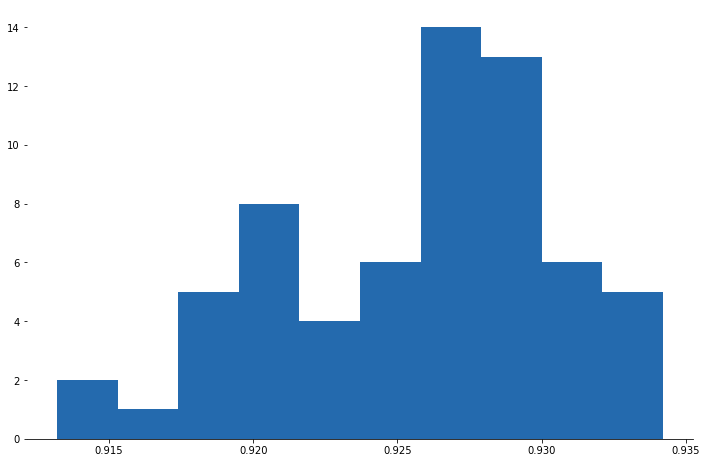

In [45]:
a.plot_hist('val_accuracy')

In [43]:
a.high('val_accuracy')

0.9341999888420105

In [50]:
a.table(metric='val_accuracy', sort_by='val_accuracy').head(3)

,epochs,second_conv_activation,optimizer,first_conv_neurons,accuracy,second_dropout,end,val_accuracy,val_loss,first_dropout,batch_size,loss,second_conv_neurons,first_dense_neurons,first_conv_activation,second_conv_kernel,first_conv_kernel,duration,eval_f1score_std,eval_f1score_mean,round_epochs,start,first_max_pool_size
62,10,relu,nadam,128,0.954833,0.5,06/13/20-163420,0.9342,0.201612,0.50,128,0.121005,128,256,relu,"(3, 3)","(3, 3)",64.094139,0.007210,0.934073,10,06/13/20-163316,"(2, 2)"
24,10,relu,nadam,128,0.960450,0.5,06/13/20-155949,0.9333,0.216650,0.25,64,0.106645,64,256,relu,"(3, 3)","(3, 3)",66.302378,0.003763,0.932945,10,06/13/20-155843,"(2, 2)"
42,10,relu,nadam,64,0.965800,0.5,06/13/20-161658,0.9326,0.229829,0.25,128,0.091076,128,256,relu,"(3, 3)","(3, 3)",55.369303,0.004685,0.932464,10,06/13/20-161603,"(2, 2)"


In [52]:
a.best_params(metric = 'val_accuracy', exclude=[], n = 1)

array([[10, 'relu', 'nadam', 128, 0.9548333287239075, 0.5,
        '06/13/20-163420', 0.20161224901676178, 0.5, 128,
        0.12100548297166824, 128, 256, 'relu', (3, 3), (3, 3),
        64.09413933753967, 0.007210241518540993, 0.9340728789261277, 10,
        '06/13/20-163316', (2, 2), 0]], dtype=object)

In [0]:
# Concludes hyper parameter optimization using talos. The val accuracy has improved to .9342 from 0.9273